# Contractor analysis
#### Segmentation of contractor using different clustering technique 

## Import required python libraries

In [356]:
import tables
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import heapq
from sklearn.metrics import silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler
from google.cloud import bigquery
from datetime import datetime, timedelta
import time
import json
import pandas as pd
import csv
import string
pd.options.display.max_colwidth = 500
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA


## Read from bigquery

In [357]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))
# read data main table for model
query = """
    select * FROM `gaf-np-ds.Contractor_Cluster.Cluster_Data_Updated` 
"""
raw_data = pd.read_gbq(query, dialect='standard')

# read oroginal data 
query = """
SELECT * FROM `gaf-np-ds.Contractor_Cluster.Contractor_Original_Data_Cluster`
"""
base_data = pd.read_gbq(query, dialect='standard')

query = """
    select * FROM `gaf-np-ds.Contractor_Cluster.sales_cluster_contractors` 
"""
cluster_data = pd.read_gbq(query, dialect='standard')


raw_data.shape

Client creating using default project: gaf-np-ds


Downloading: 100%|██████████| 51/51 [00:00<00:00, 305.22rows/s]


(12816, 26)

In [358]:
print(raw_data.shape)
#print(cluster_data.shape)
#print(cluster_data.head(2))
#print(raw_data.head(1))
#print(final.shape)


(12816, 26)


In [359]:
#base_data['certification_status'].value_counts()

In [360]:
#base_data.describe(include='all')

AxesSubplot(0.125,0.125;0.775x0.755)
Steep Slope - Residential    56065
Low Slope - Commercial       19181
Name: business_area, dtype: int64
4. Non-Certified     44464
2. Master            18415
1. Master Select      8457
3.Authorized (LS)     3910
Name: CommercialCertification, dtype: int64
1. Master Elite     29326
2. Certified        23957
3. Non-Certified    21963
Name: ResidentialCertification, dtype: int64
USA    73029
CAN     2191
MEX       26
Name: country, dtype: int64


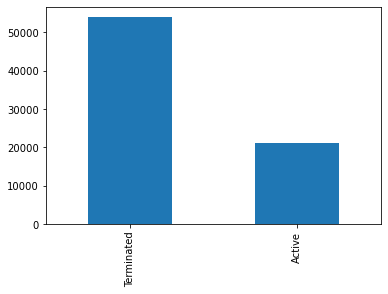

In [361]:
#plt.figure(figsize=(3,3))
print(base_data['certification_status'].value_counts().plot(kind='bar'))
print(base_data['business_area'].value_counts())
print(base_data['CommercialCertification'].value_counts())
print(base_data['ResidentialCertification'].value_counts())
print(base_data['country'].value_counts())


## Clean data

In [362]:
clean_data=raw_data.copy()
c=0
for i in raw_data.columns:
    if 'CERTIFICATION' in i:
        c=c+1
print(c)    
        
# remove columns starts with  'CERTIFICATION' will consider only count_CERTIFICATION..  
#filter_col = [col for col in raw_data if col.startswith('CERTIFICATION')]
#clean_data=raw_data.drop(filter_col, axis=1)

#removed nonrequired columns
clean_data=clean_data.drop(['state','cust_id','company_name'],axis=1)
                           
#'count_CERTIFICATION_LEVEL_MASTER_APPLICATOR','count_CERTIFICATION_LEVEL_AUTHORIZD_APPLICATOR']

#remove total_sales	max_sales	min_sales	count_sales	avg_sales as we will use onehotcode
#clean_data=clean_data.drop(['total','total_sales','max_sales','min_sales','count_sales','avg_sales'],axis=1)

#calculate total certifications we are not considering as as we deal with 0/1 data only

print(clean_data.shape)

7
(12816, 23)


In [364]:
#raw_data.head(2)

In [365]:
# convert spend to numeric 1,2,3 corresponding to low,medium,high
#fill na with 0
#clean_data['min_sales_low']=clean_data['min_sales_low'].fillna(0)
#clean_data['min_sales_medium']=clean_data['min_sales_medium'].fillna(0)
#clean_data['min_sales_high']=clean_data['min_sales_high'].fillna(0)
#clean_data['max_sales_low']=clean_data['max_sales_low'].fillna(0)
#clean_data['max_sales_medium']=clean_data['max_sales_medium'].fillna(0)
#clean_data['max_sales_high']=clean_data['max_sales_high'].fillna(0)
#clean_data['avg_sales_low']=clean_data['avg_sales_low'].fillna(0)
#clean_data['avg_sales_medium']=clean_data['avg_sales_medium'].fillna(0)
#clean_data['avg_sales_high']=clean_data['avg_sales_high'].fillna(0)
#clean_data['total_sales_low']=clean_data['total_sales_low'].fillna(0)
#clean_data['total_sales_medium']=clean_data['total_sales_medium'].fillna(0)
#clean_data['total_sales_high']=clean_data['total_sales_high'].fillna(0)

#print('NA value count in total after replacing NA with 0',clean_data[clean_data['total_sales_high'].isna()].shape)

#clean_data=clean_data.drop(['spend'],axis=1)

clean_data['total_certifications']=clean_data['count_CERTIFICATION_LEVEL_AUTHORIZED_LS']+clean_data['count_CERTIFICATION_LEVEL_MASTER_SELECT']+ \
                                   clean_data['count_master']+clean_data['count_certified']+clean_data['count_master_elite']



In [366]:
# get std of columns where close < .0001
low_std_col=[]
for i in clean_data.columns:
    std=clean_data[i].std()
    if std < .0001:
        #print(i)
        low_std_col.append(i)
        print('std of ',i,std,'removing')
clean_data=clean_data.drop(low_std_col,axis=1)        
        

std of  ResidentialCertification_Non_Certified 0.0 removing


In [367]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
                    print('corr of columns ',corr_matrix.columns[i],corr_matrix.columns[j],corr_matrix.iloc[i, j])

    
    #print(corr_matrix)
    return dataset, col_corr

# remove corelated columns; we are ignoring it as pca/svd we are doing
print('clean_data shape before column deletion for corr',clean_data.shape)    
#clean_data, cor_corr = correlation(clean_data,.4)    
print('clean_data shape after column deletion for corr',clean_data.shape)

#print('columns corelated are',cor_corr)    

# check VIF and remove column with vif>5; we are ignoring as pca is done
clean_data_x=add_constant(clean_data)
print('vif table top 5')
#print(pd.Series([vif(clean_data_x.values,i) for i in range(clean_data_x.shape[1])],index=clean_data_x.columns).sort_values(ascending=False)[:5])
#viftable=pd.Series([vif(clean_data_x.values,i) for i in range(clean_data_x.shape[1])],index=clean_data_x.columns)
print('before column deletion for vif',clean_data.shape)
#clean_data=clean_data.drop(list(viftable[viftable>5].index)[1:],axis=1)   # first item is const
print('after column deletion for vif',clean_data.shape)


clean_data shape before column deletion for corr (12816, 23)
clean_data shape after column deletion for corr (12816, 23)
vif table top 5
before column deletion for vif (12816, 23)
after column deletion for vif (12816, 23)


In [368]:
# fill na
for c in clean_data.columns:
    clean_data[c]=clean_data[c].fillna(0)


In [370]:
clean_data.head(2)

,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,CommercialCertification_Non_Certified,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_certifications
0,1,1,0,0,0,1,3,0,0,0,1,1,0,1,0,0,0,1,1.0,1.0,1.0,1.0,4
1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1.0,1.0,1.0,1.0,1


## Transform data

In [371]:
# normalize x with 0 and 1 mean and std
scaler = MinMaxScaler()
scaler = StandardScaler()  #for using pca
scaled = scaler.fit_transform(clean_data)
#print('before transformation',clean_data.values[0:2])
x_orig=clean_data.values
x_std=scaled
unscaled = scaler.inverse_transform(scaled)
#print('aftre denormalizing',unscaled[0:2])

# check how many components required to get 90% variance. for SVD use x_orig no need standarizing
for comp in range(len(x_orig[0])):
    svd = TruncatedSVD(n_components=comp, n_iter=7, random_state=42)
    svd.fit(x_orig)
    v=sum(svd.explained_variance_ratio_)
    if v > .9:
        break
    #print('SVD explained variance with component',comp,' is ',v)   #,svd.explained_variance_ratio_)


# dimension reduction by SVD
print('Before SVD x',x_orig.shape)
svd = TruncatedSVD(n_components=comp, n_iter=7, random_state=42)
svd.fit(x_orig)
print('SVD explained variance',sum(svd.explained_variance_ratio_))   #,svd.explained_variance_ratio_)
x_orig=svd.fit_transform(x_orig)
print('svd singular values',svd.singular_values_)

print('transformed x using SVD',x_orig.shape)

for comp in range(len(x_std[0])):
    svd = TruncatedSVD(n_components=comp, n_iter=7, random_state=42)
    svd.fit(x_std)
    v=sum(svd.explained_variance_ratio_)
    if v > .9:
        break
    #print('PCA explained variance with component',comp,' is ',v)   #,svd.explained_variance_ratio_)
print('Before PCA x',x_std.shape)
pca = PCA(n_components=comp)
pca.fit(x_std)
print('PCA explained variance',sum(pca.explained_variance_ratio_))  #,pca.explained_variance_ratio_)
print('pca singular values',pca.singular_values_)
x_std=svd.fit_transform(x_std)
print('transformed x using PCA',x_std.shape)

# We have x_std: pca comp of standarize data, x_orig: SVD of original data, 
# because of standarization matrix become dense so pca components are more 
# to explain 90% variance whereas svd components are less to explain 90% of variance as SVD can be used in original data

Before SVD x (12816, 23)
SVD explained variance 0.957647768064116
svd singular values [711.2665721  358.22590379 278.32075932 232.76782709 169.61196664]
transformed x using SVD (12816, 5)
Before PCA x (12816, 23)
PCA explained variance 0.9158487835609381
pca singular values [262.94489254 213.27712454 204.51015007 198.49134686 194.55055258
 171.9988849   81.72524511]
transformed x using PCA (12816, 7)


In [372]:
print(clean_data.shape,x_std[0].shape,x_orig[1].shape)

(12816, 23) (7,) (5,)


In [373]:
base_data.describe()

,kmeans_9_cluster,gmm_4_cluster,dbscan_8_cluster
count,75246.000000,75246.000000,75246.000000
mean,2.989036,1.566130,-0.614411
std,2.958350,1.286044,1.336129
min,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,-1.000000
50%,2.000000,1.000000,-1.000000
75%,6.000000,3.000000,-1.000000
max,8.000000,3.000000,6.000000


## Kmeans

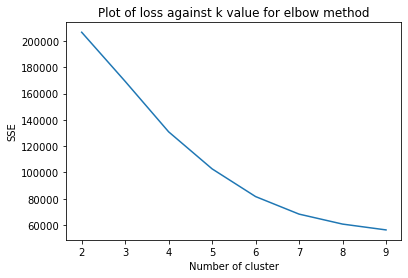

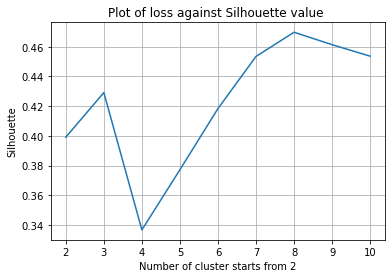

In [374]:
# Elbow method
x=x_std
sse = {}
for k in range(2, 10):
    kmeans = KMeans(init='k-means++',n_clusters=k, max_iter=1000).fit(x)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Plot of loss against k value for elbow method")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#The Silhouette Method
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(x)
  labels = kmeans.labels_
  sil.append(silhouette_score(x, labels, metric = 'euclidean'))

plt.figure()
sil1=[(i+2,item) for i,item in enumerate(sil)]

x_val = [i[0] for i in sil1]
y_val = [i[1] for i in sil1]

plt.plot(x_val,y_val)


plt.title("Plot of loss against Silhouette value ")
plt.xlabel("Number of cluster starts from 2")
plt.ylabel("Silhouette")
plt.grid()
plt.show()

In [235]:
# Use k=2 and build cluster
#kmeans = KMeans(init='k-means++',n_clusters=5, max_iter=100).fit(x)
#print(kmeans.labels_)    
#a=np.where(kmeans.labels_ == 0)[0]
#b=np.where(kmeans.labels_ == 1)[0]
#c=np.where(kmeans.labels_ == 2)[0]
#d=np.where(kmeans.labels_ == 3)[0]
#e=np.where(kmeans.labels_ == 4)[0]
#check 5 text for cluster 1
#print(clean_data.iloc[a.tolist()][:2])
#check 5 text for cluster 1
#print(clean_data.iloc[b.tolist()][:2])
#print(clean_data.iloc[c.tolist()][:2])
#print(clean_data.iloc[d.tolist()][:2])
#print(clean_data.iloc[e.tolist()][:2])


In [236]:
clean_data.shape

(12816, 25)

In [237]:
x

array([[ 1.32413731,  2.30685598, -2.70650228, ..., -0.5222999 ,
         1.82871828, -1.63000926],
       [ 2.62909412,  1.10611212, -2.3509388 , ...,  5.78590276,
        -0.53498604,  0.36493364],
       [ 3.59421347,  2.71593225, -2.17758755, ..., -0.1537701 ,
        -0.89813265,  0.0657472 ],
       ...,
       [-2.30228628,  1.83464305, -1.22822554, ...,  0.19273636,
         0.2898758 , -0.7685767 ],
       [-1.30212971,  2.1182048 , -0.21334824, ...,  0.56506799,
        -1.75026647,  0.37599817],
       [-2.30228628,  1.83464305, -1.22822554, ...,  0.19273636,
         0.2898758 , -0.7685767 ]])

In [315]:
# get top 2 cluster value by Silhouette
top_2=heapq.nlargest(1, sil)
top_2=[sil.index(j)+2 for j in top_2] 
top_2

[9]

In [239]:
# lable will be atttached with data from where model is create
final_data=raw_data.copy()

In [240]:
    
def clusterform(n_clusters=2,x=x,cluster_data=clean_data):
    # here no options to choose cosine distance
    kmeans = KMeans(init='k-means++',n_clusters=n_clusters, max_iter=100).fit(x)
    #cluster_data.head(2)
    # show by tsne
    
    return kmeans

def tsne_plot(x=x,cluster_data=clean_data,kmeans=kmeans):
    modeltsne=TSNE(n_components=2,random_state=0)#,perplexity=10,n_iter=250)
    cluster_data['cluster_kmeans']=kmeans.labels_.tolist()
    y=cluster_data['cluster_kmeans'].values
    tsne_data=modeltsne.fit_transform(x)
    #create new data for plotting
    tsne_data=np.vstack((tsne_data.T,y)).T
    tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Label'))
    sns.FacetGrid(tsne_df,hue='Label',size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
    plt.show()
    
    

for cluster  9


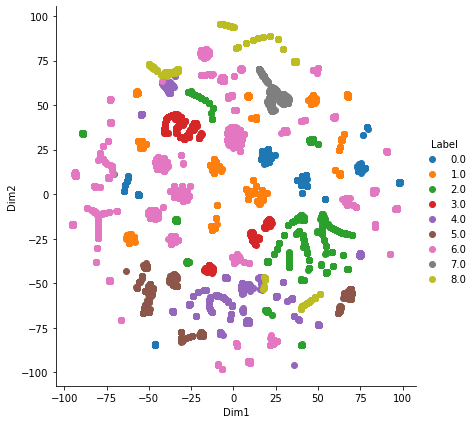

[4 5 4 ... 6 1 6]


In [241]:
import seaborn as sns
for cluster in top_2:
    print('for cluster ',cluster)
    model=clusterform(cluster,x,clean_data.copy())
    tsne_plot(x,clean_data.copy(),model)
    print(model.labels_)    
    final_data['kmeans_'+str(cluster)+'_cluster']=model.labels_
    final_data['kmeans_'+str(cluster)+'_cluster_score']=silhouette_score(x, model.labels_, metric = 'euclidean')
    clean_data['kmeans_'+str(cluster)+'_cluster']=model.labels_
    clean_data['kmeans_'+str(cluster)+'_cluster_score']=silhouette_score(x, model.labels_, metric = 'euclidean')


In [242]:
## Create a label with kmeans output
print(kmeans.labels_)    
#clean_data['kmeans_label']=kmeans.labels_
#a=np.where(kmeans.labels_ == 0)[0]
#b=np.where(kmeans.labels_ == 1)[0]
clean_data.head(2)

[6 4 6 ... 1 9 1]


,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,CommercialCertification_Non_Certified,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_certifications,kmeans_9_cluster,kmeans_9_cluster_score
0,1,1,0,0,0,1,3,0,0,0,1,1,0,1,0,0,0,1,1.0,1.0,1.0,1.0,4,4,0.459355
1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1.0,1.0,1.0,1.0,1,5,0.459355


In [243]:
final_data.head(2)

,cust_id,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,CommercialCertification_Non_Certified,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,ResidentialCertification_Non_Certified,company_name,state,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,kmeans_9_cluster,kmeans_9_cluster_score
0,1112246,1,1,0,0,0,1,3,0,0,0,1,1,0,1,0,0,0,1,0,Steel King Construction,AK,1.0,1.0,1.0,1.0,4,0.459355
1,1106740,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,United Roofing Group Inc,AK,1.0,1.0,1.0,1.0,5,0.459355


In [244]:
# fnd cluster centers


In [245]:
#get top 5 data closest to center
for c in range(2):
        d = model.transform(x)[:, c]
        ind = np.argsort(d)[::-1][:5]
        print('top 5 in cluster',c)
        print(raw_data.iloc[ind]['cust_id'])



top 5 in cluster 0
6282    1006387
5348    1003040
5366    1000157
5389    1001982
2105    1003157
Name: cust_id, dtype: object
top 5 in cluster 1
2105    1003157
6282    1006387
3727    1002535
5348    1003040
5366    1000157
Name: cust_id, dtype: object


In [375]:
#final_data.head(2)

## GMM

In [247]:
from sklearn.mixture import GaussianMixture as gmm
x=x_std

def gmmmodel(n_components=2,x=x):
    model=gmm(n_components=n_components)
    label=model.fit_predict(x)
    print('with cluster',n_components,'AIC',model.aic(x),'BIC',model.bic(x),'average log likelihood',model.score(x))
    aic=model.aic(x)
    return label,model,aic

aicno=100000
l=0
for n_components in range(2,5):     
    label,model,aic=gmmmodel(n_components,x)
    if aic< aicno:
        aicno=aic
        l=n_components
    
print(model.weights_,'best component',l)
#print('model means before trans',model.means_)

#print('model means after trans',scaler.inverse_transform(model.means_))

with cluster 2 AIC 103649.07257899326 BIC 104178.62250551414 average log likelihood -4.038197276021897
with cluster 3 AIC 76140.54903918866 BIC 76938.60315380462 average log likelihood -2.9621780992192828
with cluster 4 AIC -132615.27883484782 BIC -131548.72053213677 average log likelihood 5.18497498575405
[0.60666355 0.10533708 0.16159488 0.12640449] best component 4


In [248]:
# no of cluster = 2 has low logscore and aic bic 
model=gmm(n_components=l)
label=model.fit_predict(x)
#print(label) 
top_2_gmm=l
final_data['gmm_'+str(l)+'_cluster']=label
final_data['gmm_'+str(l)+'_cluster_log_score']=model.score(x)
clean_data['gmm_'+str(l)+'_cluster']=label
clean_data['gmm_'+str(l)+'_cluster_log_score']=model.score(x)

In [250]:
clean_data.head(2)

,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,CommercialCertification_Non_Certified,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_certifications,kmeans_9_cluster,kmeans_9_cluster_score,gmm_4_cluster,gmm_4_cluster_log_score
0,1,1,0,0,0,1,3,0,0,0,1,1,0,1,0,0,0,1,1.0,1.0,1.0,1.0,4,4,0.459355,0,2.28561
1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1.0,1.0,1.0,1.0,1,5,0.459355,2,2.28561


## DBSCAN

In [251]:
x=x_orig
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
sscore=-100
eps1=.5
for eps in [.45,.4,.3,.2,.25,.35]:
    db = DBSCAN(eps=eps, min_samples=200).fit(x)
    #db = dbscan(x,eps=eps, min_samples=200)
    #labels=db.labels_
    labels=db.labels_
    cluster=len(set(labels)) - (1 if -1 in labels else 0)
    # -1 labels are outliers
    score=metrics.silhouette_score(x,labels)
    print('DBSCAN no of cluster by model',len(set(labels)),cluster,score)
    if score>sscore:
        sscore=score
        eps1=eps
        
        
print('best eps',eps1)        
db = DBSCAN(eps=eps1, min_samples=200).fit(x)
labels=db.labels_
score=metrics.silhouette_score(x,labels)
top_2_dbscan=len(set(labels))    
final_data['dbscan_'+str(len(set(labels)))+'_cluster']=labels
final_data['dbscan_'+str(len(set(labels)))+'_cluster_score']=score
clean_data['dbscan_'+str(len(set(labels)))+'_cluster']=label
clean_data['dbscan_'+str(len(set(labels)))+'_cluster_score']=score
clean_data.head(2)


DBSCAN no of cluster by model 9 8 0.15222300737844538
DBSCAN no of cluster by model 9 8 0.132185142686656
DBSCAN no of cluster by model 10 9 0.14450585527828363
DBSCAN no of cluster by model 10 9 0.1320609832303444
DBSCAN no of cluster by model 10 9 0.14450585527828363
DBSCAN no of cluster by model 9 8 0.132185142686656
best eps 0.45


,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,CommercialCertification_Non_Certified,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_certifications,kmeans_9_cluster,kmeans_9_cluster_score,gmm_4_cluster,gmm_4_cluster_log_score,dbscan_9_cluster,dbscan_9_cluster_score
0,1,1,0,0,0,1,3,0,0,0,1,1,0,1,0,0,0,1,1.0,1.0,1.0,1.0,4,4,0.459355,0,2.28561,0,0.152223
1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1.0,1.0,1.0,1.0,1,5,0.459355,2,2.28561,2,0.152223


In [252]:
db

DBSCAN(algorithm='auto', eps=0.45, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=200, n_jobs=None, p=None)

## AgglomerativeClustering

In [253]:
x=x_orig
for cluster in [4]:
    model=AgglomerativeClustering(n_clusters=cluster).fit(x)
    final_data['hierarchical_'+str(cluster)+'_cluster']=model.labels_
    final_data['hierarchical_'+str(cluster)+'_cluster_score']='NA'
    clean_data['hierarchical_'+str(cluster)+'_cluster']=model.labels_
    clean_data['hierarchical_'+str(cluster)+'_cluster_score']='NA'
top_2_agg=4
    

In [376]:
print(final_data.shape)
#final_data.head(1)

(12816, 34)


In [255]:
print(clean_data.shape)
clean_data.head(1)

(12816, 31)


,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,CommercialCertification_Non_Certified,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_certifications,kmeans_9_cluster,kmeans_9_cluster_score,gmm_4_cluster,gmm_4_cluster_log_score,dbscan_9_cluster,dbscan_9_cluster_score,hierarchical_4_cluster,hierarchical_4_cluster_score
0,1,1,0,0,0,1,3,0,0,0,1,1,0,1,0,0,0,1,1.0,1.0,1.0,1.0,4,4,0.459355,0,2.28561,0,0.152223,1,NA


In [256]:
#clean_data=clean_data.drop(['kmeans_2_cluster_score','kmeans_2_cluster'],axis=1)

## Merge clusters output and store back to bigquery

In [306]:
# merge original data with cluster labels
#final_data has input for model
use_col=[c for c in final_data.columns.tolist() if 'cluster' in c]
use_col.append('cust_id')
print(use_col)
final_data1=final_data[use_col]
final_data1.head(2)

#drop columns from bas data where clusetr 
drop_col=[c for c in base_data.columns.tolist() if 'cluster' in c]
base_data1=base_data.drop(drop_col,axis=1)
print(base_data1.shape)
print(base_data.shape)

#final2 has data original+cluster label
final2=pd.merge(base_data1,final_data1,how='left', on='cust_id')
print(final_data1.shape,base_data1.shape,final2.shape)

['kmeans_9_cluster', 'kmeans_9_cluster_score', 'gmm_4_cluster', 'gmm_4_cluster_log_score', 'dbscan_9_cluster', 'dbscan_9_cluster_score', 'hierarchical_4_cluster', 'hierarchical_4_cluster_score', 'cust_id']
(75246, 12)
(75246, 15)
(12816, 9) (75246, 12) (75246, 20)


In [261]:
# Store feature data with label
final_data.to_gbq(destination_table='Contractor_Cluster.Contractor_Featured_Cluster_updated',project_id = 'gaf-np-ds',if_exists = 'replace')  #'replace')

1it [00:05,  5.95s/it]


In [307]:
# store original data with feature
final2.to_gbq(destination_table='Contractor_Cluster.Contractor_Original_Cluster_updated',project_id = 'gaf-np-ds',if_exists = 'replace')  #'replace')

1it [00:12, 12.34s/it]


In [298]:
final2.head(1)

,cust_id,certification_level_cd,start_date,expiration_date,certification_status,business_area,CommercialCertification,ResidentialCertification,company_name,zip_code,state,country,kmeans_9_cluster,kmeans_9_cluster_score,gmm_4_cluster,gmm_4_cluster_log_score,dbscan_9_cluster,dbscan_9_cluster_score,hierarchical_4_cluster,hierarchical_4_cluster_score
0,1000353,QUICKQUOTES,2017-04-06,2018-04-30,Terminated,Steep Slope - Residential,4. Non-Certified,1. Master Elite,Lang Brothers Construction Inc,47712,IN,USA,2.0,0.459355,3.0,2.28561,-1.0,0.152223,0.0,NA


## FInd important features of clusters

In [318]:
# for kmeans
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
drop_col=[c for c in clean_data.columns.tolist() if 'cluster' in c]
x=clean_data.drop(drop_col, axis=1).values 
y=clean_data['kmeans_'+str(top_2[0])+'_cluster']
clf.fit(x, y)
feat_importance = clf.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))
good_features=[]
for importance, name in sorted(zip(clf.feature_importances_, clean_data.drop(['kmeans_'+str(top_2[0])+'_cluster'], axis=1).columns),reverse=True)[:5]:
    print (name, importance)
    good_features.append(name)
    
good_features

feat importance = [4.81835639e-02 1.36067063e-01 0.00000000e+00 0.00000000e+00
 5.66107389e-03 4.13823630e-03 5.03927382e-05 0.00000000e+00
 4.27818728e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.53217569e-03 0.00000000e+00 8.14002369e-03 1.37146267e-01
 3.42819257e-02 0.00000000e+00 1.82420203e-01 9.34067195e-03
 0.00000000e+00 4.10724705e-02 1.76468937e-01]
_2019_Low_Slope__Commercial 0.2205046987470629
total_certifications 0.21331096661104385
CommercialCertification_Non_Certified 0.16577876746770326
CERTIFICATION_LEVEL_CERTIFIED 0.1644742544677674
CERTIFICATION_LEVEL_MASTER 0.058243013075050726


['_2019_Low_Slope__Commercial',
 'total_certifications',
 'CommercialCertification_Non_Certified',
 'CERTIFICATION_LEVEL_CERTIFIED',
 'CERTIFICATION_LEVEL_MASTER']

9

In [313]:
clean_data.head(1)

,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,CommercialCertification_Non_Certified,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_certifications,kmeans_9_cluster,kmeans_9_cluster_score,gmm_4_cluster,gmm_4_cluster_log_score,dbscan_9_cluster,dbscan_9_cluster_score,hierarchical_4_cluster,hierarchical_4_cluster_score
0,1,1,0,0,0,1,3,0,0,0,1,1,0,1,0,0,0,1,1.0,1.0,1.0,1.0,4,4,0.459355,0,2.28561,0,0.152223,1,NA


In [132]:
clean_data.head(1)

,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,CommercialCertification_Non_Certified,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_certifications,kmeans_9_cluster,kmeans_9_cluster_score
0,1,1,0,0,0,1,3,0,0,0,1,1,0,1,0,0,0,1,1.0,1.0,1.0,1.0,4,2,0.462093


## Show data variablility in clusters

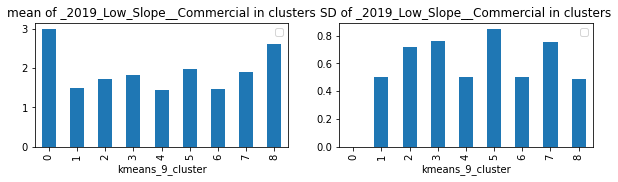

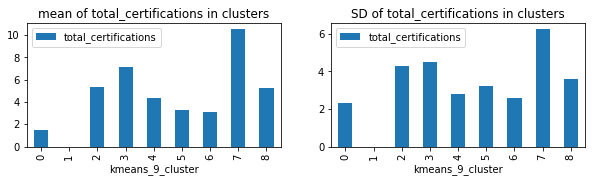

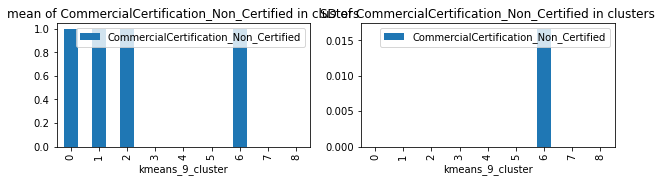

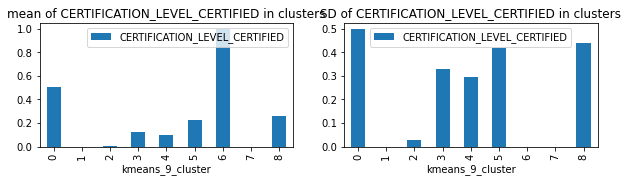

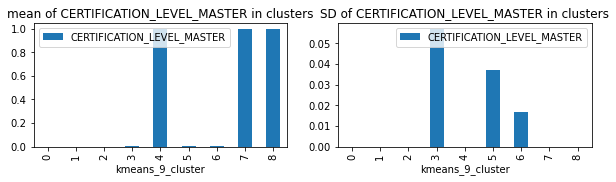

In [320]:
import warnings
warnings.filterwarnings('ignore')
for c in good_features:
    if 'cluster' in c or c in remove_col:
        pass
    else:
        
        #print('kmeans clusters mean/std value ',c,' in different clusters\n')
        #print('---------------------------------')
        ax1 = plt.subplot(221)
        my_df=clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].mean().reset_index()
        my_df.plot(x='kmeans_'+str(top_2[0])+'_cluster', y=c, kind='bar',ax=ax1,figsize=(10, 5)) 
        plt.title('mean of '+c+' in clusters')
        #plt.subplot(1, 2, 2)
        my_df=clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].std().reset_index()
        ax2 = plt.subplot(222)
        my_df.plot(x='kmeans_'+str(top_2[0])+'_cluster', y=c, kind='bar',ax=ax2,figsize=(10, 5)) 
        plt.title('SD of '+c+' in clusters')
        plt.show()
        #print(clean_data.groupby('gmm_4_cluster')[c].mean().reset_index())


## Feature importance from GMM

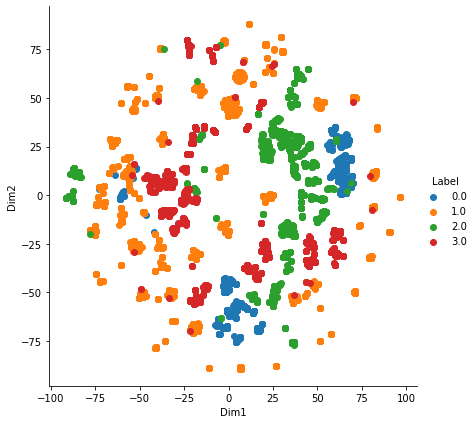

In [337]:
# t-SNE for GMM
modeltsne=TSNE(n_components=2,random_state=0)#,perplexity=10,n_iter=250)
model=gmm(n_components=top_2_gmm)
label=model.fit_predict(x_orig)
y=label
tsne_data=modeltsne.fit_transform(x)
#create new data for plotting
tsne_data=np.vstack((tsne_data.T,y)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Label'))
sns.FacetGrid(tsne_df,hue='Label',size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

feat importance = [0.         0.         0.         0.01500729 0.         0.19955211
 0.30496514 0.         0.         0.00885869 0.         0.05288563
 0.         0.         0.07904241 0.         0.00031197 0.
 0.         0.         0.         0.         0.        ]
count_certified 0.46163248383512306
count_master 0.30206645241704627
CommercialCertification_Authorized_LS 0.11964824064899061
Low_Slope_Commercial 0.08005414255418616
CERTIFICATION_LEVEL_AUTHORIZED_LS 0.022716859552239423


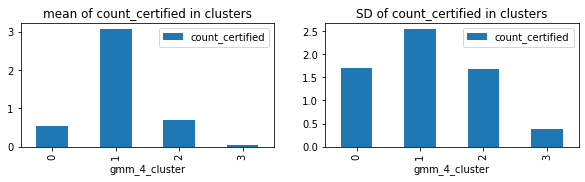

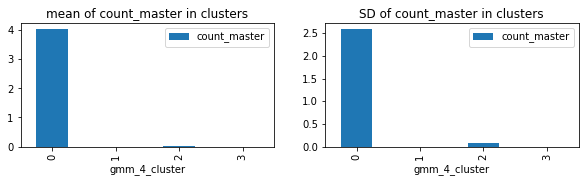

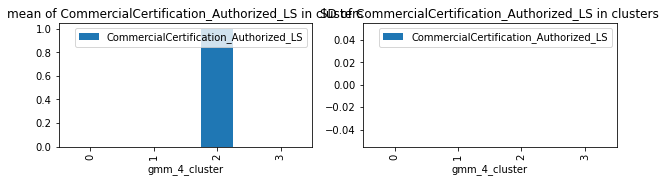

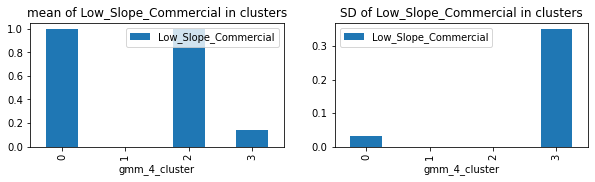

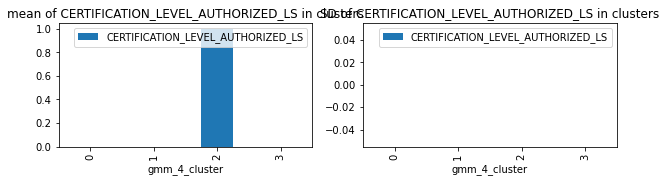

In [338]:
# for gmm
clf = DecisionTreeClassifier()
drop_col=[c for c in clean_data.columns.tolist() if 'cluster' in c]
x=clean_data.drop(drop_col, axis=1).values 
y=clean_data['gmm_'+str(top_2_gmm)+'_cluster']
clf.fit(x, y)
feat_importance = clf.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))
good_features=[]
for importance, name in sorted(zip(clf.feature_importances_, clean_data.drop(['gmm_'+str(top_2_gmm)+'_cluster'], axis=1).columns),reverse=True)[:5]:
    print (name, importance)
    good_features.append(name)
    
good_features

for c in good_features:
        ax1 = plt.subplot(221)
        my_df=clean_data.groupby('gmm_'+str(top_2_gmm)+'_cluster')[c].mean().reset_index()
        my_df.plot(x='gmm_'+str(top_2_gmm)+'_cluster', y=c, kind='bar',ax=ax1,figsize=(10, 5)) 
        plt.title('mean of '+c+' in clusters')
        my_df=clean_data.groupby('gmm_'+str(top_2_gmm)+'_cluster')[c].std().reset_index()
        ax2 = plt.subplot(222)
        my_df.plot(x='gmm_'+str(top_2_gmm)+'_cluster', y=c, kind='bar',ax=ax2,figsize=(10, 5)) 
        plt.title('SD of '+c+' in clusters')
        plt.show()    
        



[0, 1, 2, 3, 4, 'y']

## Plot SVD components with cluster

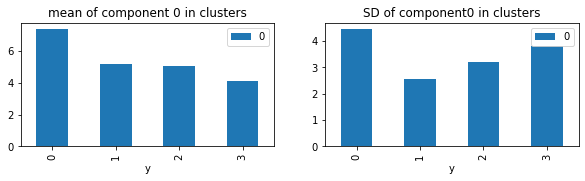

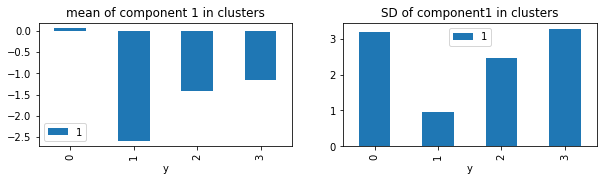

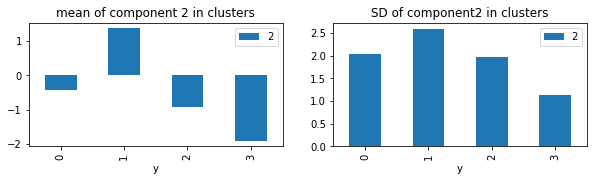

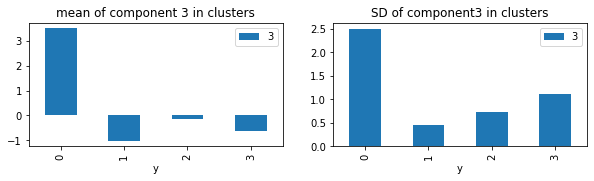

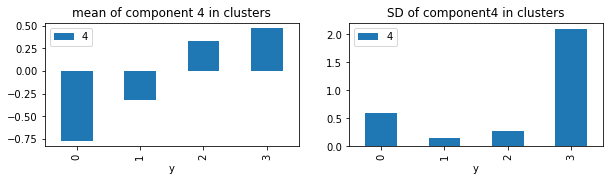

In [355]:
t=pd.DataFrame(np.array(x_orig))
t['y']=clean_data['gmm_4_cluster']
t

# plot with svd components
for c in t.columns.tolist():
        if c=='y':
            continue
        ax1 = plt.subplot(221)
        my_df=t.groupby('y')[c].mean().reset_index()
        my_df.plot(x='y', y=c, kind='bar',ax=ax1,figsize=(10, 5)) 
        plt.title('mean of component '+str(c)+' in clusters')
        my_df=t.groupby('y')[c].std().reset_index()
        ax2 = plt.subplot(222)
        my_df.plot(x='y', y=c, kind='bar',ax=ax2,figsize=(10, 5)) 
        plt.title('SD of component'+str(c)+' in clusters')
        plt.show()    

        

In [347]:
t.columns

Index([0, 1, 2, 3, 4, 'y'], dtype='object')